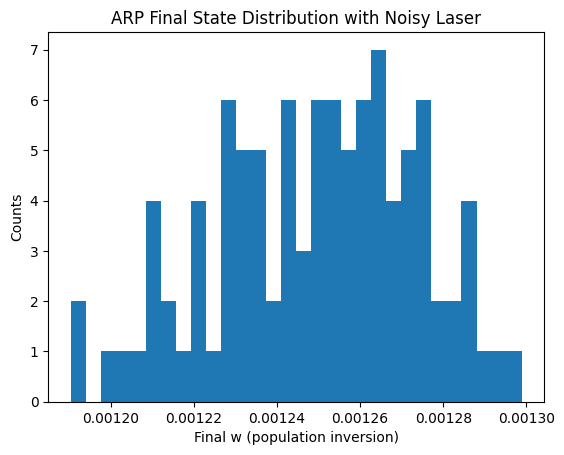

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# User parameters
# -----------------------------
Omega = 2*np.pi*50        # Rabi frequency (Hz)
Delta0 = -2*np.pi*40000     # Starting detuning (Hz)
Delta1 = +2*np.pi*40000     # Ending detuning (Hz)
T = 0.01                 # total sweep duration (seconds)

gamma_lw = 2*np.pi*30     # laser linewidth (Hz) → phase diffusion rate
noise_bw = 200000           # noise bandwidth (Hz)
samples = 100             # ensemble realizations

dt = 1e-6                 # timestep
N = int(T/dt)

# -----------------------------
# Helper: Generate phase noise
# -----------------------------
def generate_phase_noise(gamma, bw, dt, N):
    """
    OU-like filtered noise approximating phase diffusion
    """
    tau = 1/(2*np.pi*bw)
    sigma = np.sqrt(2*gamma)
    phi = np.zeros(N)
    for i in range(1, N):
        phi[i] = phi[i-1] * np.exp(-dt/tau) + \
                 sigma * np.sqrt(dt) * np.random.randn()
    return phi

# -----------------------------
# Bloch equation propagator
# -----------------------------
def evolve_bloch(Omega, Delta_t, dt):
    """
    Solve dR/dt = M R for Bloch vector R = (u, v, w)
    No relaxation terms included (purely coherent dynamics)
    """
    R = np.array([0.0, 0.0, -1.0])  # start in |g>

    for d in Delta_t:
        # Hamiltonian in rotating frame
        # u = <sigma_x>, v = <sigma_y>, w = <sigma_z>
        dudt = -d * R[1]
        dvdt = d * R[0] - Omega * R[2]
        dwdt = Omega * R[1]

        R += dt * np.array([dudt, dvdt, dwdt])
        # Normalize slightly to maintain Bloch length
        R /= np.linalg.norm(R)

    return R

# -----------------------------
# Main simulation
# -----------------------------
w_final = []

time = np.linspace(0, T, N)
Delta_nominal = Delta0 + (Delta1 - Delta0) * time / T

for _ in range(samples):
    phi_noise = generate_phase_noise(gamma_lw, noise_bw, dt, N)
    dDelta = np.gradient(phi_noise, dt)   # noisy instantaneous detuning
    Delta_total = Delta_nominal + dDelta

    R = evolve_bloch(Omega, Delta_total, dt)
    w_final.append(R[2])   # record final inversion

# -----------------------------
# Plot
# -----------------------------
plt.hist(w_final, bins=30)
plt.xlabel("Final w (population inversion)")
plt.ylabel("Counts")
plt.title("ARP Final State Distribution with Noisy Laser")
plt.show()

In [27]:
np.std(w_final)

np.float64(2.4138826623912435e-05)